In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage.data import shepp_logan_phantom
from skimage.transform import resize, radon

import torch
import torch.nn.functional as F
import math
import time

In [2]:
def shepp_logan_phantom_generator(output_size=256):
    """
    Generate a Shepp-Logan phantom at a specified resolution.

    Args:
        output_size (int): The side length of the output square image.

    Returns:
        np.ndarray: The generated Shepp-Logan phantom image.
    """
    # Ellipse parameters: [Amplitude, Center X, Center Y, Major Axis, Minor Axis, Angle (degrees)]
    # Standard Shepp-Logan parameters scaled for a [-1, 1] coordinate range
    ellipses = [
        [ 1.0,  0.0,      0.0,      0.92,  0.69,   90.0],  # Large background ellipse
        [-0.8,  0.0,     -0.0184,   0.874, 0.6624, 90.0],  # Inner dark ellipse
        [-0.2,  0.22,     0.0,      0.31,  0.11,   72.0],  # Right top ellipse
        [-0.2, -0.22,     0.0,      0.41,  0.16,  108.0],  # Left top ellipse
        [ 0.1,  0.0,      0.35,     0.25,  0.21,   90.0],  # Top middle ellipse
        [ 0.1,  0.0,      0.1,      0.046, 0.046,  0.0],   # Center small ellipse 1
        [ 0.1,  0.0,     -0.1,      0.046, 0.046,  0.0],   # Center small ellipse 2
        [ 0.1, -0.08,    -0.605,    0.046, 0.023,  0.0],   # Bottom left ellipse
        [ 0.1,  0.0,     -0.605,    0.023, 0.023,  0.0],   # Bottom middle ellipse
        [ 0.1,  0.06,    -0.605,    0.046, 0.023,  90.0]   # Bottom right ellipse
    ]

    # Create coordinate grid
    x = np.linspace(-1, 1, output_size)
    y = np.linspace(-1, 1, output_size)
    xx, yy = np.meshgrid(x, y)
    coords = np.stack((xx.ravel(), yy.ravel()), axis=-1)

    phantom = np.zeros(output_size * output_size)

    for A, cx, cy, ax_maj, ax_min, angle_deg in ellipses:
        angle_rad = np.deg2rad(angle_deg)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)

        # Center coordinates relative to ellipse center
        xc = coords[:, 0] - cx
        yc = coords[:, 1] - cy

        # Rotate coordinates
        x_rot = xc * cos_a + yc * sin_a
        y_rot = -xc * sin_a + yc * cos_a

        # Check if point is inside the ellipse
        # Use a small epsilon to avoid division by zero if axes are zero
        epsilon = 1e-12
        inside = (x_rot**2 / (ax_maj**2 + epsilon) + y_rot**2 / (ax_min**2 + epsilon)) <= 1
        phantom[inside] += A

    return np.clip(phantom.reshape((output_size, output_size)), 0.0, 1.0)

def fft_radon_transform(image, angles):
    """
    Fast Radon Transform using Fourier Slice Theorem (no GUI version).
    """
    # Step 1: Square padding if needed
    if image.shape[0] != image.shape[1]:
        max_dim = max(image.shape)
        padded = np.zeros((max_dim, max_dim))
        x_offset = (max_dim - image.shape[1]) // 2
        y_offset = (max_dim - image.shape[0]) // 2
        padded[y_offset:y_offset+image.shape[0], x_offset:x_offset+image.shape[1]] = image
        image = padded

    n = image.shape[0]

    # Step 2: Padding based on sqrt(2)
    padded_size = int(np.ceil(n * np.sqrt(2)))
    if padded_size % 2 == 1:
        padded_size += 1  # Make even
    pad = (padded_size - n) // 2
    padded_img = np.zeros((padded_size, padded_size))
    padded_img[pad:pad+n, pad:pad+n] = image

    # Optional: Apply circular mask
    x, y = np.ogrid[:padded_size, :padded_size]
    center = padded_size // 2
    mask = (x - center)**2 + (y - center)**2 <= (n//2)**2
    padded_img *= mask

    # Step 3: 2D FFT
    fft_img = fftshift(fft2(ifftshift(padded_img)))

    # Step 4: Initialize sinogram
    diag_len = int(np.ceil(np.sqrt(2) * n))
    sinogram = np.zeros((diag_len, len(angles)))

    # Step 5: For each angle, extract radial slice
    y_mid = x_mid = fft_img.shape[0] // 2

    for i, angle in enumerate(angles):
        theta = np.deg2rad(angle)

        steps = np.arange(-diag_len//2, diag_len//2)
        x_coords = x_mid + steps * np.cos(theta)
        y_coords = y_mid + steps * np.sin(theta)

        # Integer indices for bilinear interpolation
        x0, y0 = np.floor(x_coords).astype(int), np.floor(y_coords).astype(int)
        x1, y1 = x0 + 1, y0 + 1

        # Valid sampling points
        valid = (x0 >= 0) & (x0 < padded_size-1) & (y0 >= 0) & (y0 < padded_size-1)

        dx, dy = x_coords - x0, y_coords - y0

        samples = np.zeros(diag_len, dtype=complex)

        for j in np.where(valid)[0]:
            w00 = (1 - dx[j]) * (1 - dy[j])
            w01 = (1 - dx[j]) * dy[j]
            w10 = dx[j] * (1 - dy[j])
            w11 = dx[j] * dy[j]

            samples[j] = (
                w00 * fft_img[y0[j], x0[j]] +
                w01 * fft_img[y1[j], x0[j]] +
                w10 * fft_img[y0[j], x1[j]] +
                w11 * fft_img[y1[j], x1[j]]
            )

        # 1D inverse FFT to get projection
        projection = np.real(np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(samples))))
        sinogram[:, i] = projection

    return sinogram

def fft_radon_transform_torch(image, angles, device='cpu', dtype=torch.float32, circle=True, debug=False):
    """
    Fast Radon Transform using the Fourier Slice Theorem in PyTorch.

    Parameters
    ----------
    image : np.ndarray or torch.Tensor, shape (H, W)
        Input 2D image.
    angles : sequence of floats
        Projection angles (in degrees).
    device : str or torch.device
        Where to do the computation ('cpu' or 'cuda').
    dtype : torch.dtype
        Float type for internal computations.

    Returns
    -------
    sinogram : np.ndarray, shape (diag_len, len(angles))
        The reconstructed sinogram.
    """
    device = torch.device(device)
    
    if debug:
        print(f"Using device: {device}, dtype: {dtype}")

    # 0) Prepare input
    if not torch.is_tensor(image):
        img = torch.tensor(image, dtype=dtype, device=device)
    else:
        img = image.to(dtype=dtype, device=device)
    H, W = img.shape

    # 1) Square‐pad
    if H != W:
        M = max(H, W)
        padded = torch.zeros((M, M), dtype=dtype, device=device)
        xoff = (M - W) // 2
        yoff = (M - H) // 2
        padded[yoff:yoff+H, xoff:xoff+W] = img
        img = padded
        n = M
    else:
        n = H

    # 2) Diagonal padding + circular mask
    side = int(math.ceil(n * math.sqrt(2)))
    if side % 2: side += 1
    pad_amt = (side - n) // 2
    padded_img = torch.zeros((side, side), dtype=dtype, device=device)
    padded_img[pad_amt:pad_amt+n, pad_amt:pad_amt+n] = img

    coords = torch.arange(side, device=device)
    xx = coords.view(-1,1); yy = coords.view(1,-1)
    ctr = side // 2
    mask = (xx-ctr)**2 + (yy-ctr)**2 <= (n//2)**2
    padded_img_before_mask = padded_img.clone()
    padded_img *= mask

    if debug:
        print("Original image shape:", img.shape)
        print("Padded image shape:", padded_img.shape)
        # plot original and padded image before mask and padded image after mask
        plt.figure(figsize=(9, 9))
        plt.subplot(1, 3, 1)
        plt.imshow(img.cpu().numpy(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(padded_img_before_mask.cpu().numpy(), cmap='gray')
        plt.title('Padded Image Before Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(padded_img.cpu().numpy(), cmap='gray')
        plt.title('Padded Image After Mask')
        plt.axis('off')
        plt.show()

    # 3) 2D FFT with shifts → complex tensor
    Fimg = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(padded_img)))

    if debug:
        print("FFT image shape:", Fimg.shape)
        plt.figure(figsize=(6, 6))
        plt.imshow(torch.log1p(torch.abs(Fimg)).cpu().numpy(), cmap='gray')
        plt.title('FFT Magnitude Spectrum')
        plt.axis('off')
        plt.show()

    # Split into real & imaginary for grid_sample
    Finp_real = Fimg.real.unsqueeze(0).unsqueeze(0)  # shape (1,1,side,side)
    Finp_imag = Fimg.imag.unsqueeze(0).unsqueeze(0)

    # 4) Allocate sinogram
    diag_len = int(math.ceil(math.sqrt(2)*n))
    sino_t = torch.zeros((diag_len, len(angles)), dtype=dtype, device=device)

    mid = side // 2
    for i, angle in enumerate(angles):
        th = math.radians(angle)
        steps = torch.arange(-diag_len//2, diag_len//2, device=device, dtype=dtype)

        # Coordinates in FFT plane (this one works with real - 1j * imag and plotting should reverse the columns)
        #x_coords = mid + steps * math.cos(th)
        #y_coords = mid + steps * math.sin(th)

        # new: sample along –θ, because scikit-image does a +θ rotation then sums
        x_coords = mid + steps * math.cos(th)
        y_coords = mid - steps * math.sin(th)    # ← flip the sign here

        # Normalize to [-1,1] for grid_sample
        x_norm = (x_coords / (side - 1)) * 2 - 1
        y_norm = (y_coords / (side - 1)) * 2 - 1
        grid = torch.stack((x_norm, y_norm), dim=1).view(1, diag_len, 1, 2)

        # Bilinear interpolate real & imag parts
        slice_real = F.grid_sample(Finp_real, grid,
                                  mode='bilinear',
                                  padding_mode='zeros',
                                  align_corners=True)[0,0,:,0]
        slice_imag = F.grid_sample(Finp_imag, grid,
                                  mode='bilinear',
                                  padding_mode='zeros',
                                  align_corners=True)[0,0,:,0]

        # Recombine to complex, then 1D iFFT with shifts
        #slice_c = slice_real - 1j * slice_imag
        slice_c = slice_real + 1j * slice_imag
        #slice_c = (slice_real - 1j * slice_imag).flip(0) # *** conjugate + reverse to match skimage’s rotate‐then‐sum *** 

        proj = torch.real(
                 torch.fft.ifftshift(
                   torch.fft.ifft(
                     torch.fft.fftshift(slice_c)
                   )
                 )
               )

        sino_t[:, i] = proj
    
    if debug:
        print("diag_len:", diag_len)
        print(f"Slice shape: {slice_c.shape}, Projection shape: {proj.shape}")

    # 6) optional crop to circle (height = min(H, W))
    if circle:
        L = min(H, W)
        start = (diag_len - L) // 2
        sino_t = sino_t[start:start+L, :]

    return sino_t.cpu().numpy()

#sinogram_torch = fft_radon_transform_torch(phantom, angles, device=device, debug=True)

Time taken for fast Radon transform (device = cpu): 0.1838 seconds
Time taken for skimage Radon transform: 6.5768 seconds


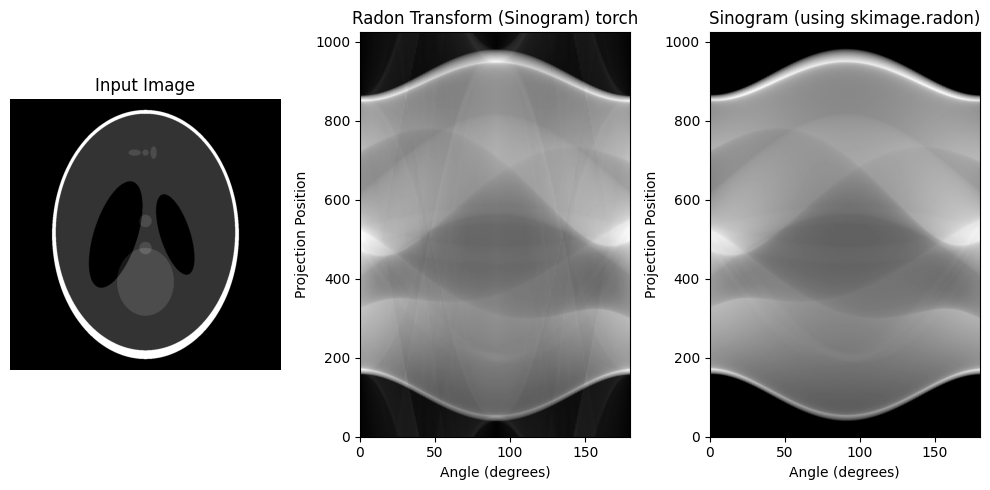

In [4]:
# Step A: Generate test image (Shepp-Logan Phantom)
size = 1024
phantom = shepp_logan_phantom_generator(output_size=size)

#phantom = shepp_logan_phantom()
#phantom = resize(phantom, (size, size))

# Step B: Define angles
angles = np.linspace(0., 180., 180, endpoint=False)

# Run fast Radon transform
#sinogram = fft_radon_transform(phantom, angles)

# Run fast Radon transform using PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
start = time.time()
sinogram_torch = fft_radon_transform_torch(phantom, angles, device=device)
end = time.time()
print(f"Time taken for fast Radon transform (device = {device}): {end - start:.4f} seconds")

# Compute Sinogram using skimage Radon
start = time.time()
sinogram_skimage = radon(phantom, theta=angles, circle=True)
end = time.time()
print(f"Time taken for skimage Radon transform: {end - start:.4f} seconds")

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(phantom, cmap='gray')
plt.axis('off')

"""plt.subplot(1, 4, 2)
plt.title('Radon Transform (Sinogram)')
plt.imshow(sinogram, cmap='gray', aspect='auto',
           extent=(0, 180, 0, sinogram.shape[0]))
plt.xlabel('Angle (degrees)')
plt.ylabel('Projection Position')
"""

plt.subplot(1, 3, 2)
plt.title('Radon Transform (Sinogram) torch')
#plt.imshow(sinogram_torch[:, ::-1], cmap='gray', aspect='auto',
#           extent=(0, 180, 0, sinogram_torch.shape[0]))
plt.imshow(sinogram_torch, cmap='gray', aspect='auto',
           extent=(0, 180, 0, sinogram_torch.shape[0]))
plt.xlabel('Angle (degrees)')
plt.ylabel('Projection Position')

plt.subplot(1, 3, 3)
plt.title('Sinogram (using skimage.radon)')
plt.imshow(sinogram_skimage, cmap='gray', aspect='auto',
           extent=(0, 180, 0, sinogram_skimage.shape[0]))
plt.xlabel('Angle (degrees)')
plt.ylabel('Projection Position')

plt.tight_layout()
plt.show()

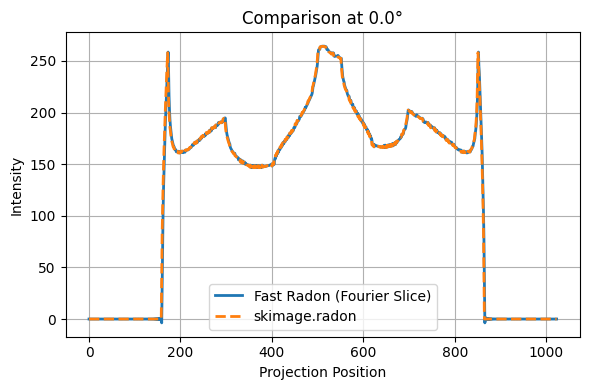

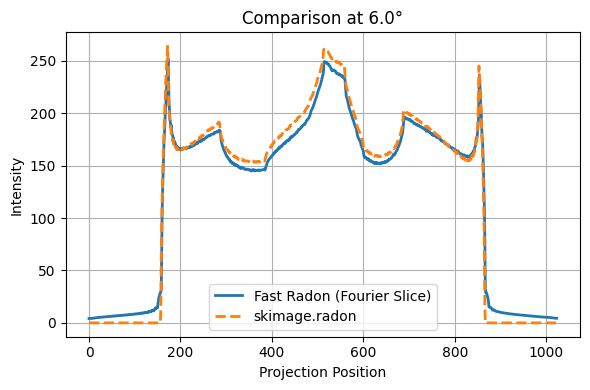

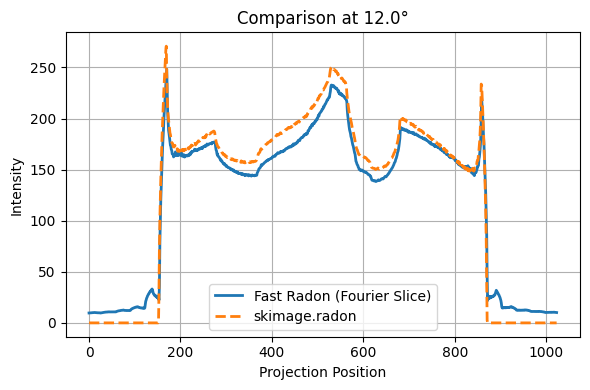

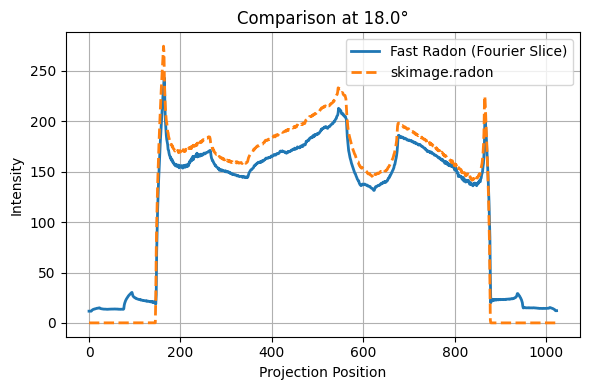

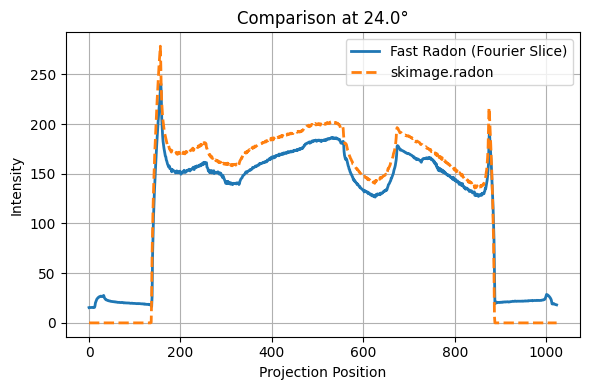

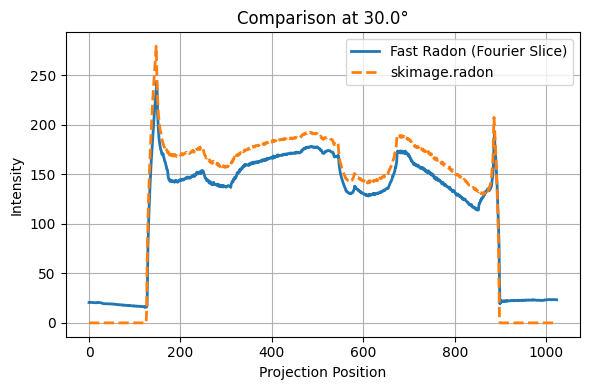

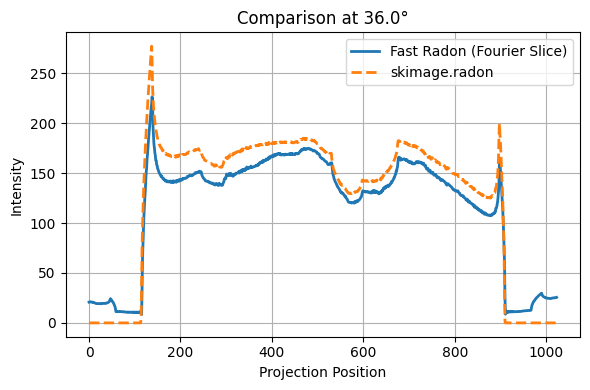

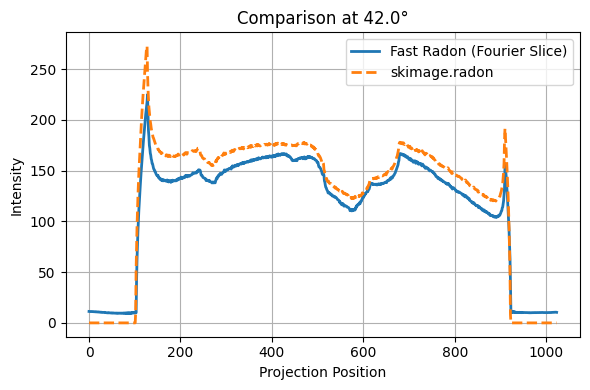

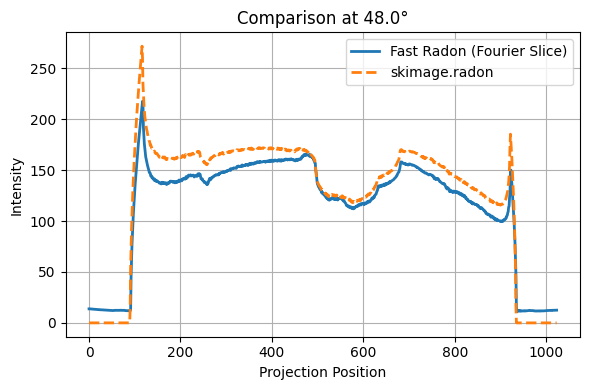

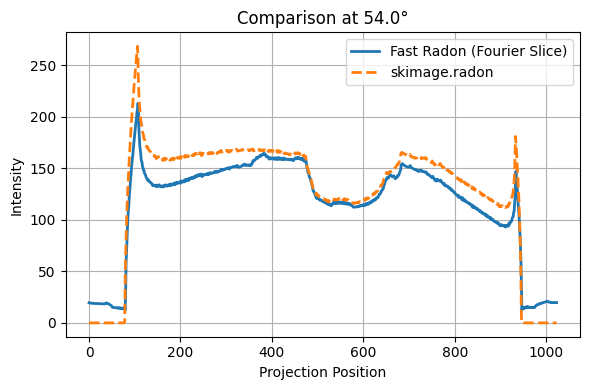

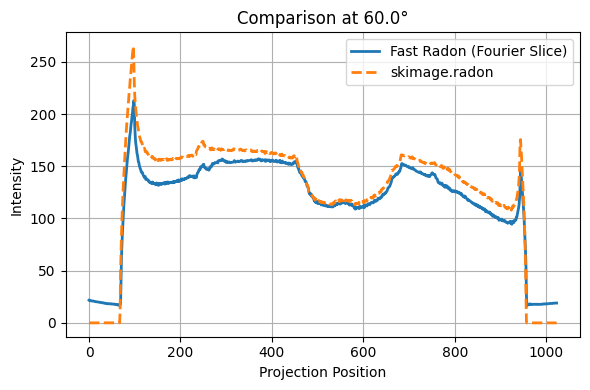

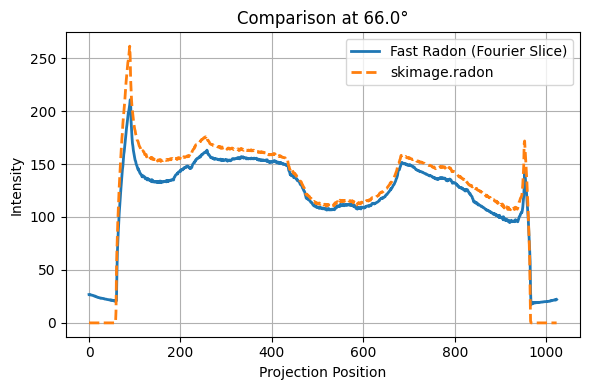

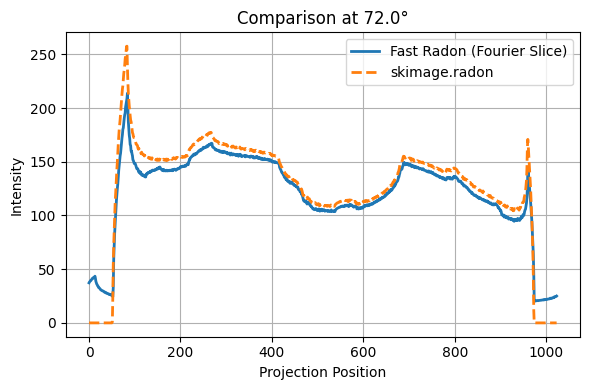

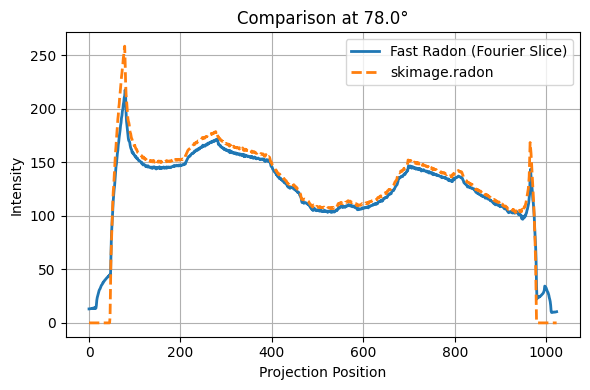

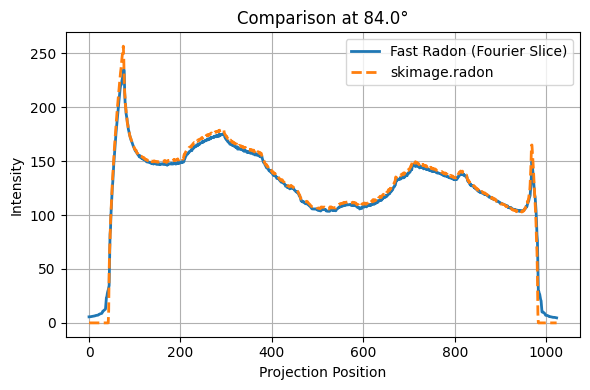

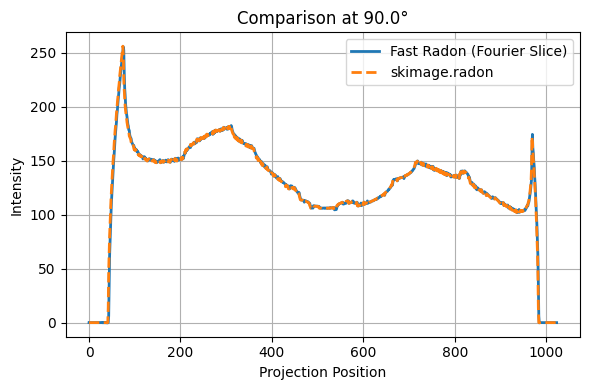

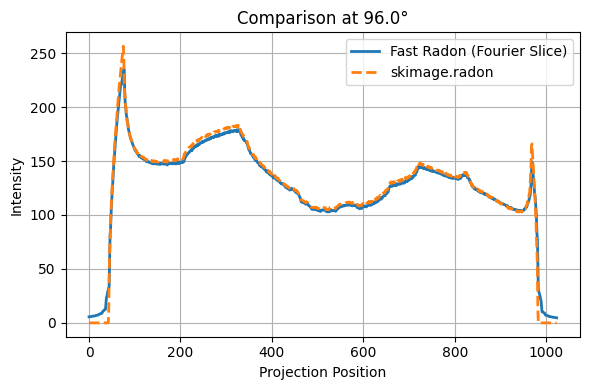

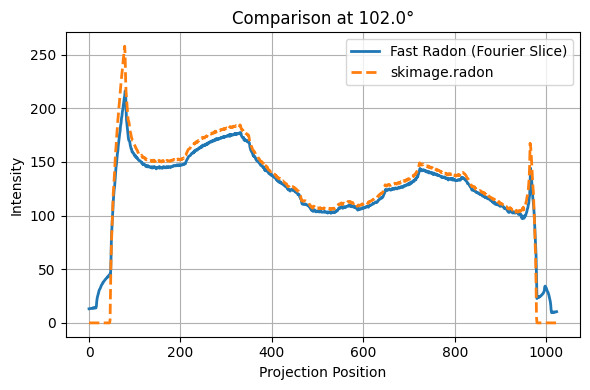

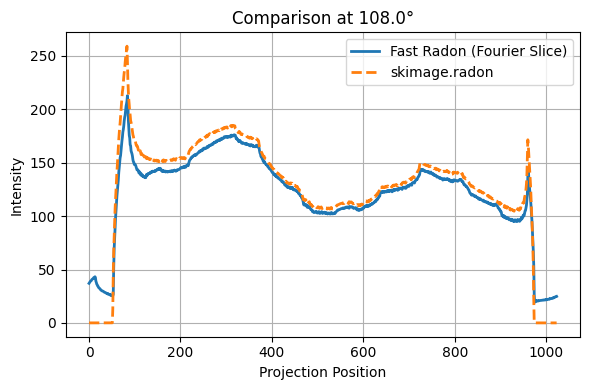

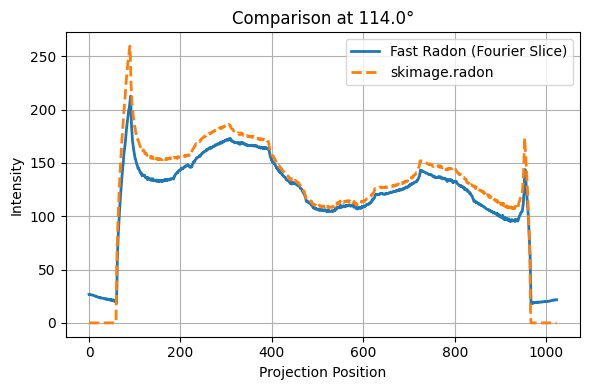

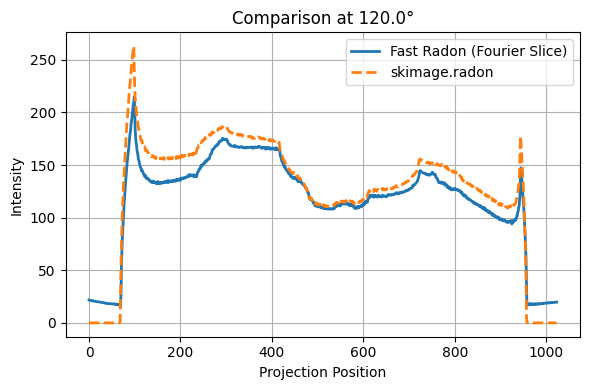

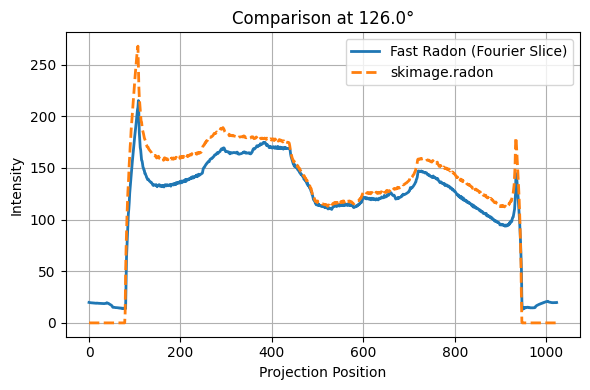

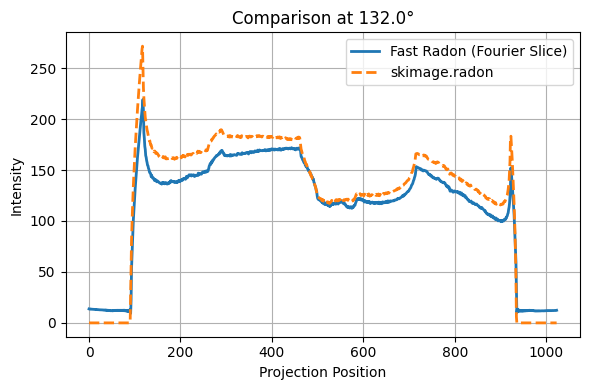

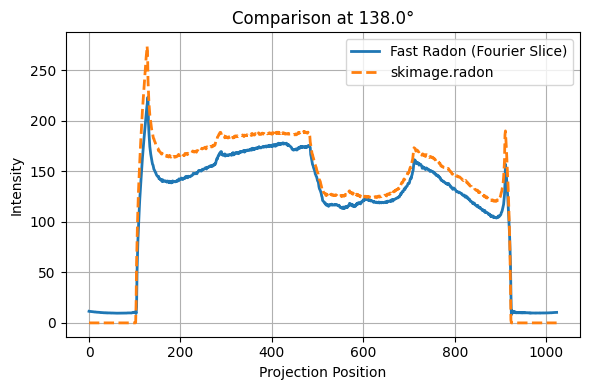

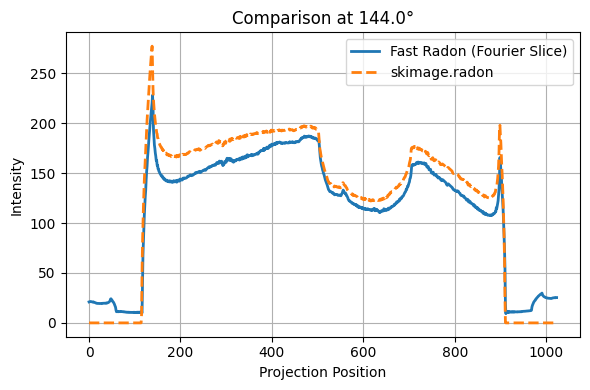

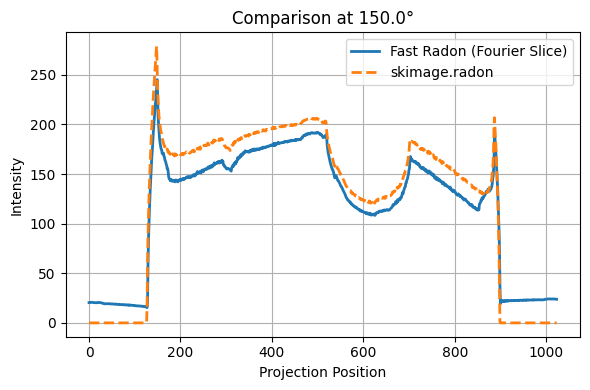

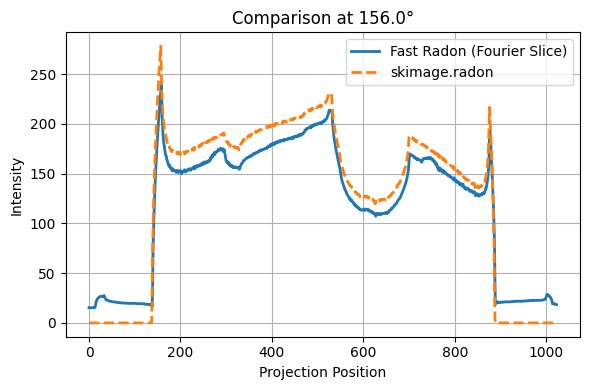

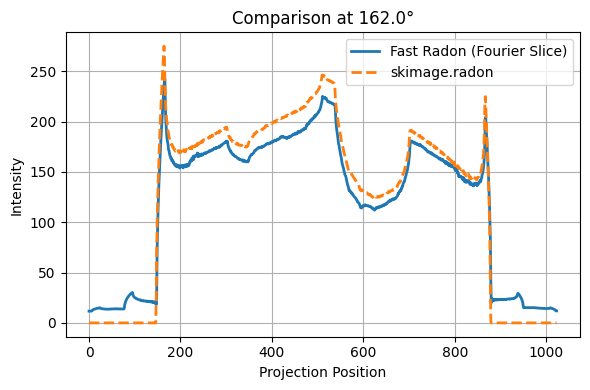

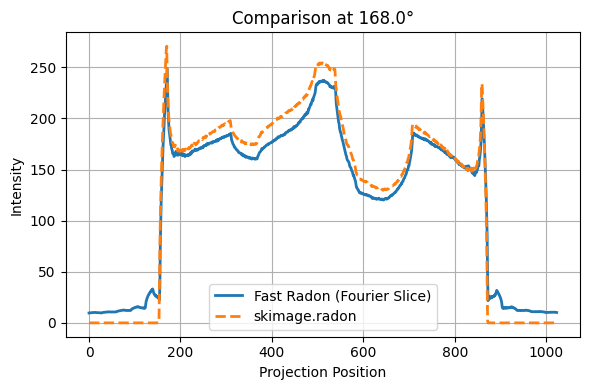

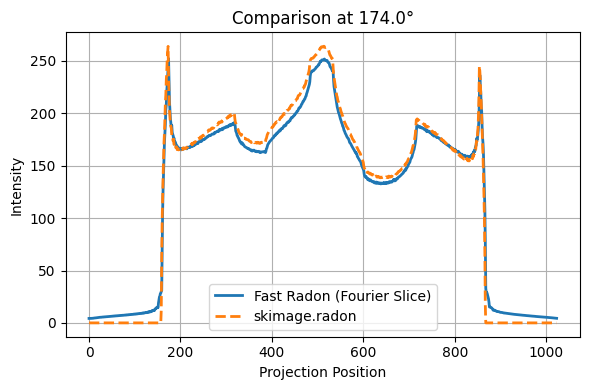

In [6]:
# Step F: Pick angles to compare (indices in the angles array)
compare_angles = np.linspace(0., 180., 30, endpoint=False)

# Find corresponding indices
angle_indices = [np.argmin(np.abs(angles - a)) for a in compare_angles]

# Step G: Plot the 1D profiles
for idx, angle_idx in enumerate(angle_indices):
    plt.figure(figsize=(6, 4))
    fast_proj = sinogram_torch[:, angle_idx]
    #fast_proj = fast_proj[::-1]
    plt.plot(fast_proj, label='Fast Radon (Fourier Slice)', linewidth=2)
    plt.plot(sinogram_skimage[:, angle_idx], '--', label='skimage.radon', linewidth=2)
    plt.title(f'Comparison at {angles[angle_idx]:.1f}°')
    plt.xlabel('Projection Position')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()